In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler

In [2]:
garlic = pd.read_csv("이상치제거.csv",encoding='euc=kr')
garlic


,Unnamed: 0,시점,시군산지,일자,품종,도매가격.원.kg.,거래량.톤.,거래금액.백만원.,마늘.면적..ha.,X10a당.생산량..kg.,생산량..톤.,X10a당.생산량.톤,평균,평균기온..C.,일강수량.mm.,평균.풍속.m.s.,합계.일조시간.hr.,평균.지면온도..C.,평균.5cm.지중온도..C.
0,1,2015,철원,2015-07-11,기타,5833,0.020,0.11,307,777,2385,0.777,0.020000,19.655000,6.984375,1.670718,6.382320,21.770166,22.154190
1,2,2015,철원,2015-07-10,기타,6875,0.020,0.11,307,777,2385,0.777,0.020000,19.635556,6.984375,1.661326,6.392265,21.734254,22.115642
2,3,2015,평창,2015-08-06,햇마늘 한지,10000,0.010,0.10,307,777,2385,0.777,0.010000,19.214917,7.308475,1.570166,6.323204,21.660773,22.070950
3,4,2015,홍천,2015-09-21,저장형 한지,3125,0.040,0.13,307,777,2385,0.777,0.040000,15.548066,7.444286,1.483425,4.768508,17.203867,17.888268
4,5,2016,강릉,2016-07-02,햇마늘 한지,2500,0.040,0.10,180,807,1452,0.807,0.040000,20.027072,11.755263,1.431492,6.052486,23.000552,22.607735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,1348,2020,횡성,2020-09-03,깐마늘,5500,0.006,0.03,236,1049,2476,1.049,0.074962,17.055801,12.382278,1.549171,4.667403,20.296133,19.737017
1348,1349,2020,횡성,2020-07-31,깐마늘,5300,0.010,0.07,236,1049,2476,1.049,0.074962,19.151381,11.896591,1.540331,4.939227,22.667403,21.890608
1349,1350,2020,횡성,2020-08-07,깐마늘,4900,0.010,0.07,236,1049,2476,1.049,0.074962,18.760221,12.016092,1.549171,4.937017,22.270718,21.537017
1350,1351,2020,횡성,2020-06-01,마늘쫑,5245,0.030,0.17,236,1049,2476,1.049,0.074962,16.776796,10.508046,1.856906,5.798343,19.967403,19.060221


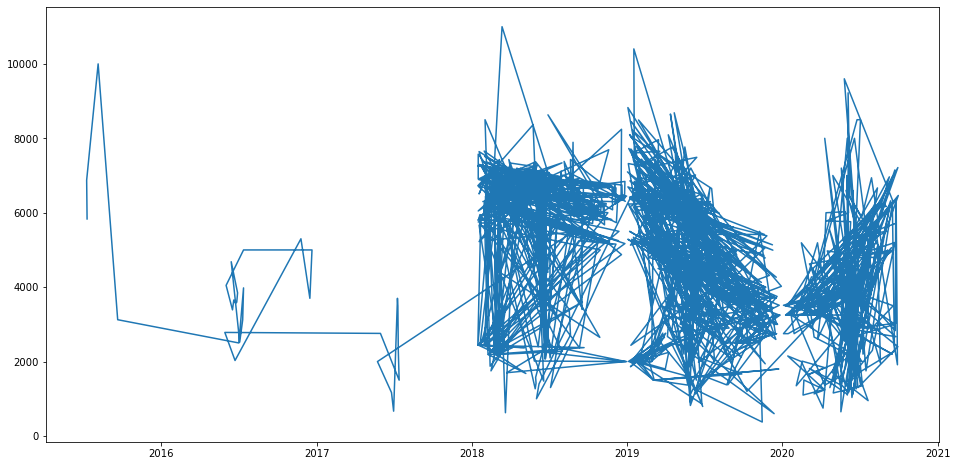

In [3]:
garlic["일자"]=pd.to_datetime(garlic['일자'],format="%Y-%m-%d")
garlic.index=garlic['일자']
plt.figure(figsize=(16,8))
plt.plot(garlic["도매가격.원.kg."],label='Close Price history')

In [4]:
data=garlic.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(garlic)),columns=['일자','도매가격.원.kg.'])

for i in range(0,len(data)):
    new_dataset["일자"][i]=data['일자'][i]
    new_dataset["도매가격.원.kg."][i]=data["도매가격.원.kg."][i]

In [5]:

scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset['일자']
new_dataset.drop("일자",axis=1,inplace=True)
final_dataset=new_dataset.values

train_data=final_dataset[0:500,:]
valid_data=final_dataset[500:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [6]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

440/440 - 13s - loss: 0.0276


In [7]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_price=lstm_model.predict(X_test)
predicted_price=scaler.inverse_transform(predicted_price)

In [8]:
lstm_model.save("saved_model.h5")

<ipython-input-9-35420cbd4e9c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_price


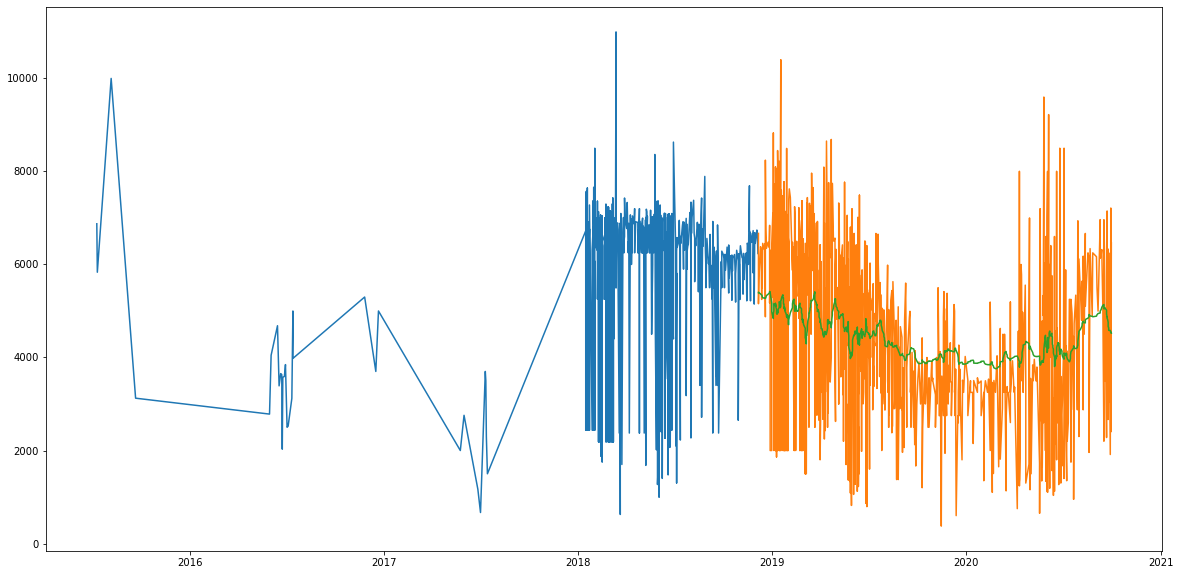

In [9]:
train_data=new_dataset[:500] 
valid_data=new_dataset[500:] 
valid_data['Predictions']=predicted_price
plt.plot(train_data["도매가격.원.kg."]) 
plt.plot(valid_data[['도매가격.원.kg.',"Predictions"]])

